# Neural Style Transfer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

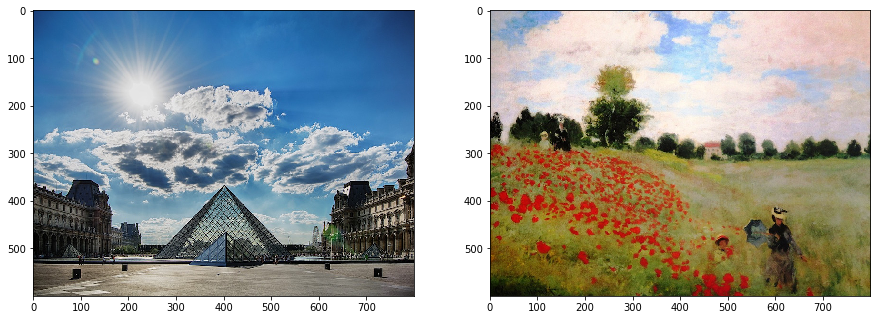

In [2]:
content_img = np.array(plt.imread('content_image.jpg'))
style_img = np.array(plt.imread('style_image.jpg'))

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(content_img)
ax2.imshow(style_img)

In [3]:
content_image = np.array(Image.fromarray(content_img).resize((224,224)), dtype='float32')
style_image = np.array(Image.fromarray(style_img).resize((224,224)), dtype='float32')

In [4]:
vgg19 = tf.keras.applications.VGG19(weights='imagenet',
                                    include_top=True)
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
y_content_image = vgg19.predict(np.expand_dims(content_image, axis=0))
tf.keras.applications.vgg19.decode_predictions(y_content_image, top=10)

[[('n03388043', 'fountain', 0.6496852),
  ('n03877845', 'palace', 0.083280735),
  ('n03933933', 'pier', 0.06887616),
  ('n02980441', 'castle', 0.05307997),
  ('n04366367', 'suspension_bridge', 0.047153477),
  ('n03673027', 'liner', 0.016833063),
  ('n04311004', 'steel_arch_bridge', 0.008029246),
  ('n03344393', 'fireboat', 0.006739203),
  ('n03028079', 'church', 0.006031915),
  ('n09428293', 'seashore', 0.005757659)]]

In [6]:
y_style_image = vgg19.predict(np.expand_dims(style_image, axis=0))
tf.keras.applications.vgg19.decode_predictions(y_style_image, top=10)

[[('n03888257', 'parachute', 0.088642165),
  ('n02321529', 'sea_cucumber', 0.07458761),
  ('n09332890', 'lakeside', 0.05700285),
  ('n02403003', 'ox', 0.056184303),
  ('n03388043', 'fountain', 0.052738074),
  ('n02410509', 'bison', 0.048590757),
  ('n09421951', 'sandbar', 0.024270622),
  ('n03868242', 'oxcart', 0.022848908),
  ('n09256479', 'coral_reef', 0.022403894),
  ('n02408429', 'water_buffalo', 0.021656588)]]

In [7]:
content = {'block4_conv2':1e2}

style = {'block1_conv1':1e4,
         'block2_conv1':1e4,
         'block3_conv1':1e4,
         'block4_conv1':1e4,
         'block5_conv1':1e4}

In [8]:
class ContentLayer(tf.keras.layers.Layer):
    
    def __init__(self, model, content_layers):
        super().__init__()
        self.model = model
        self.content_layers = content_layers
      
    def call(self, inputs): 
        outputs = []
        y = inputs  
        for layer in self.model.layers:
            y = layer(y)          
            if layer.name in self.content_layers:
                outputs.append(y)
        return outputs

In [9]:
class StyleLayer(tf.keras.layers.Layer):
    
    def __init__(self, model, style_layers):
        super().__init__()
        self.model = model
        self.style_layers = style_layers
        
    def call(self, inputs): 
        outputs = []
        y = inputs  
        for layer in self.model.layers:
            y = layer(y)          
            if layer.name in self.style_layers:
                y_ = tf.einsum('dijs, dijt ->dst',y,y)
                outputs.append(y_)
        return outputs

In [10]:
class LossFunction(tf.keras.losses.Loss):
    
    def __init__(self, content_weights, style_weights):
        super().__init__()
        self.content_weights = content_weights
        self.style_weights = style_weights
        
    def call(self, y_true, y_pred):        
        content_loss = 0.
        for i in range(len(self.content_weights)):
            content_loss = content_loss+self.content_weights[i]*tf.math.reduce_mean(tf.square(y_true[0][i]-y_pred[i]))
        style_loss = 0.
        for i in range(len(self.style_weights)):
            style_loss = style_loss+self.style_weights[-i-1]*tf.math.reduce_mean(tf.square(y_true[1][-i-1]-y_pred[-i-1]))   
        return content_loss + style_loss

In [11]:
class NeuralTransfer(tf.keras.Model):
    
    def __init__(self, model, content, style):
        super().__init__()
        self.content = content
        self.style = style
        self.f1 = ContentLayer(model=model, content_layers=list(self.content.keys()))
        self.f2 = StyleLayer(model=model, style_layers=list(self.style.keys()))
            
    def call(self, inputs): 
        a1 = self.f1(inputs)
        a2 = self.f2(inputs)
        y = a1+a2
        return y
    
    def fit(self, content_image, style_image, learning_rate=2.0, epochs=1000, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
        loss = LossFunction(content_weights=list(self.content.values()), style_weights=list(self.style.values()))
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        X_init = tf.expand_dims(tf.constant(content_image, dtype='float32'), axis=0)
        X = tf.Variable(initial_value=X_init, trainable=True)
        Y = [self(tf.expand_dims(tf.constant(content_image, dtype='float32'), axis=0)), 
             self(tf.expand_dims(tf.constant(style_image, dtype='float32'), axis=0))]
        for epoch in range(epochs):
            start_time = tf.timestamp()
            with tf.GradientTape() as tape:
                H = self(X)
                L = loss(Y,H)
            grads = tape.gradient(L, X)
            optimizer.apply_gradients([(grads, X)])
            X.assign(tf.clip_by_value(X, clip_value_min=0.0, clip_value_max=255.0))
            now = tf.timestamp()
            time = now - start_time
            H = self(X)
            L = loss(Y, H)
            tf.print('Epochs {}/{} - Loss: {}'.format(epoch+1, epochs, L))
            tf.print('--- {}s ---'.format(tf.round(1000*time)/1000))   
        self.generated_image = tf.cast(tf.math.floor(tf.squeeze(X, axis=0)), dtype='uint8').numpy()

In [12]:
neural_transfer = NeuralTransfer(model=vgg19,
                                 content=content,
                                 style=style)

neural_transfer.fit(content_image=content_image, style_image=style_image)

Epochs 1/1000 - Loss: 1.455936776122751e+21
--- 1.666s ---
Epochs 2/1000 - Loss: 1.2003959186037963e+21
--- 1.85s ---
Epochs 3/1000 - Loss: 1.0339158547784186e+21
--- 1.635s ---
Epochs 4/1000 - Loss: 9.141192602654333e+20
--- 1.684s ---
Epochs 5/1000 - Loss: 8.26631559847948e+20
--- 1.808s ---
Epochs 6/1000 - Loss: 7.635447844240213e+20
--- 2.219s ---
Epochs 7/1000 - Loss: 7.188950421871075e+20
--- 2.465s ---
Epochs 8/1000 - Loss: 6.838168565332396e+20
--- 2.654s ---
Epochs 9/1000 - Loss: 6.52397775207866e+20
--- 1.876s ---
Epochs 10/1000 - Loss: 6.223658729364668e+20
--- 1.918s ---
Epochs 11/1000 - Loss: 5.937417677610859e+20
--- 1.975s ---
Epochs 12/1000 - Loss: 5.673400482643239e+20
--- 2.566s ---
Epochs 13/1000 - Loss: 5.4358229359254936e+20
--- 2.359s ---
Epochs 14/1000 - Loss: 5.2226661581871645e+20
--- 2.909s ---
Epochs 15/1000 - Loss: 5.028624346117256e+20
--- 2.5s ---
Epochs 16/1000 - Loss: 4.8496326492083454e+20
--- 1.9s ---
Epochs 17/1000 - Loss: 4.684848049905184e+20
--- 2.

--- 1.884s ---
Epochs 137/1000 - Loss: 3.3284825014360605e+19
--- 1.88s ---
Epochs 138/1000 - Loss: 3.2753167161865798e+19
--- 1.851s ---
Epochs 139/1000 - Loss: 3.2233005802951016e+19
--- 1.827s ---
Epochs 140/1000 - Loss: 3.1724571835058094e+19
--- 1.82s ---
Epochs 141/1000 - Loss: 3.1227240735582454e+19
--- 1.781s ---
Epochs 142/1000 - Loss: 3.0740904752384573e+19
--- 1.832s ---
Epochs 143/1000 - Loss: 3.0265464929417953e+19
--- 1.818s ---
Epochs 144/1000 - Loss: 2.980056722393845e+19
--- 1.855s ---
Epochs 145/1000 - Loss: 2.934610388380654e+19
--- 1.946s ---
Epochs 146/1000 - Loss: 2.8901628507301347e+19
--- 2.116s ---
Epochs 147/1000 - Loss: 2.8466738673167106e+19
--- 2.019s ---
Epochs 148/1000 - Loss: 2.8040963790427128e+19
--- 2.102s ---
Epochs 149/1000 - Loss: 2.762443360145349e+19
--- 2.045s ---
Epochs 150/1000 - Loss: 2.721689741759506e+19
--- 2.043s ---
Epochs 151/1000 - Loss: 2.681829586522394e+19
--- 2.034s ---
Epochs 152/1000 - Loss: 2.6428345270340157e+19
--- 1.856s ---


--- 1.8s ---
Epochs 271/1000 - Loss: 9.611925152459653e+18
--- 1.838s ---
Epochs 272/1000 - Loss: 9.582324100416668e+18
--- 1.878s ---
Epochs 273/1000 - Loss: 9.56082205102388e+18
--- 1.822s ---
Epochs 274/1000 - Loss: 9.543484951677108e+18
--- 1.815s ---
Epochs 275/1000 - Loss: 9.529115434213704e+18
--- 1.796s ---
Epochs 276/1000 - Loss: 9.499749677659062e+18
--- 1.78s ---
Epochs 277/1000 - Loss: 9.441342520479973e+18
--- 1.731s ---
Epochs 278/1000 - Loss: 9.34478560835194e+18
--- 1.759s ---
Epochs 279/1000 - Loss: 9.24634853134041e+18
--- 1.776s ---
Epochs 280/1000 - Loss: 9.191930952102707e+18
--- 1.803s ---
Epochs 281/1000 - Loss: 9.18214090056899e+18
--- 1.808s ---
Epochs 282/1000 - Loss: 9.172235400314356e+18
--- 1.821s ---
Epochs 283/1000 - Loss: 9.129905851912421e+18
--- 1.847s ---
Epochs 284/1000 - Loss: 9.061993416711209e+18
--- 1.854s ---
Epochs 285/1000 - Loss: 8.992654365172957e+18
--- 1.867s ---
Epochs 286/1000 - Loss: 8.948598583515415e+18
--- 1.846s ---
Epochs 287/1000 

--- 2.101s ---
Epochs 406/1000 - Loss: 6.230264991048532e+18
--- 1.998s ---
Epochs 407/1000 - Loss: 6.080520853194277e+18
--- 1.95s ---
Epochs 408/1000 - Loss: 6.09641869182029e+18
--- 1.926s ---
Epochs 409/1000 - Loss: 6.120481503794168e+18
--- 1.969s ---
Epochs 410/1000 - Loss: 5.997473090680914e+18
--- 1.94s ---
Epochs 411/1000 - Loss: 6.050651520314114e+18
--- 2.108s ---
Epochs 412/1000 - Loss: 6.01791301184127e+18
--- 2.386s ---
Epochs 413/1000 - Loss: 5.94169101751314e+18
--- 2.027s ---
Epochs 414/1000 - Loss: 5.987116240903078e+18
--- 1.95s ---
Epochs 415/1000 - Loss: 5.936446347048649e+18
--- 1.917s ---
Epochs 416/1000 - Loss: 5.888577459065979e+18
--- 1.965s ---
Epochs 417/1000 - Loss: 5.919944326783173e+18
--- 1.942s ---
Epochs 418/1000 - Loss: 5.874392659556041e+18
--- 2.109s ---
Epochs 419/1000 - Loss: 5.832556242119164e+18
--- 1.933s ---
Epochs 420/1000 - Loss: 5.851393625082036e+18
--- 2.214s ---
Epochs 421/1000 - Loss: 5.821777179876262e+18
--- 1.861s ---
Epochs 422/1000

--- 1.869s ---
Epochs 541/1000 - Loss: 4.799973536393331e+18
--- 1.849s ---
Epochs 542/1000 - Loss: 4.784989941685813e+18
--- 2.022s ---
Epochs 543/1000 - Loss: 4.712589300020019e+18
--- 1.82s ---
Epochs 544/1000 - Loss: 4.693162029068845e+18
--- 1.886s ---
Epochs 545/1000 - Loss: 4.897778943974703e+18
--- 1.912s ---
Epochs 546/1000 - Loss: 5.499419062310011e+18
--- 1.95s ---
Epochs 547/1000 - Loss: 6.152462998511288e+18
--- 1.935s ---
Epochs 548/1000 - Loss: 6.177120096519979e+18
--- 1.903s ---
Epochs 549/1000 - Loss: 4.951104708166025e+18
--- 4.826s ---
Epochs 550/1000 - Loss: 4.70319067462579e+18
--- 1.888s ---
Epochs 551/1000 - Loss: 5.48402205123045e+18
--- 1.892s ---
Epochs 552/1000 - Loss: 5.075599111244218e+18
--- 1.903s ---
Epochs 553/1000 - Loss: 4.894245663358845e+18
--- 1.931s ---
Epochs 554/1000 - Loss: 5.540949815514366e+18
--- 1.966s ---
Epochs 555/1000 - Loss: 5.265203294384423e+18
--- 1.969s ---
Epochs 556/1000 - Loss: 5.31447021140181e+18
--- 1.934s ---
Epochs 557/100

--- 1.861s ---
Epochs 675/1000 - Loss: 3.7536260445993697e+18
--- 1.855s ---
Epochs 676/1000 - Loss: 3.82055194299256e+18
--- 1.878s ---
Epochs 677/1000 - Loss: 3.9307521451538514e+18
--- 1.932s ---
Epochs 678/1000 - Loss: 4.0712672572824617e+18
--- 1.913s ---
Epochs 679/1000 - Loss: 4.206559139423322e+18
--- 1.923s ---
Epochs 680/1000 - Loss: 4.224442421171192e+18
--- 1.916s ---
Epochs 681/1000 - Loss: 4.1395708437452554e+18
--- 1.89s ---
Epochs 682/1000 - Loss: 4.2736763528397455e+18
--- 1.84s ---
Epochs 683/1000 - Loss: 4.614381471182881e+18
--- 1.848s ---
Epochs 684/1000 - Loss: 4.940624163330064e+18
--- 1.841s ---
Epochs 685/1000 - Loss: 4.826537737320399e+18
--- 1.841s ---
Epochs 686/1000 - Loss: 4.66789635137418e+18
--- 1.87s ---
Epochs 687/1000 - Loss: 4.941250884957897e+18
--- 1.842s ---
Epochs 688/1000 - Loss: 5.528808458364649e+18
--- 1.918s ---
Epochs 689/1000 - Loss: 5.275681640197128e+18
--- 1.873s ---
Epochs 690/1000 - Loss: 5.033203592144617e+18
--- 1.882s ---
Epochs 69

--- 1.911s ---
Epochs 809/1000 - Loss: 3.3578659051523277e+18
--- 1.946s ---
Epochs 810/1000 - Loss: 3.2483034197351465e+18
--- 1.896s ---
Epochs 811/1000 - Loss: 3.280961114103349e+18
--- 1.891s ---
Epochs 812/1000 - Loss: 3.279568307748864e+18
--- 1.831s ---
Epochs 813/1000 - Loss: 3.21272817126264e+18
--- 1.793s ---
Epochs 814/1000 - Loss: 3.2488036975257846e+18
--- 1.796s ---
Epochs 815/1000 - Loss: 3.1927819308231557e+18
--- 1.789s ---
Epochs 816/1000 - Loss: 3.1981623909736776e+18
--- 1.867s ---
Epochs 817/1000 - Loss: 3.217702361866699e+18
--- 1.869s ---
Epochs 818/1000 - Loss: 3.1687556776109015e+18
--- 1.888s ---
Epochs 819/1000 - Loss: 3.194430098753192e+18
--- 1.926s ---
Epochs 820/1000 - Loss: 3.1759376875635343e+18
--- 1.938s ---
Epochs 821/1000 - Loss: 3.1601852593502945e+18
--- 1.867s ---
Epochs 822/1000 - Loss: 3.1875801413121475e+18
--- 1.856s ---
Epochs 823/1000 - Loss: 3.1676619384191713e+18
--- 1.969s ---
Epochs 824/1000 - Loss: 3.177823899760984e+18
--- 1.79s ---
E

--- 1.791s ---
Epochs 943/1000 - Loss: 3.1113696918561096e+18
--- 1.835s ---
Epochs 944/1000 - Loss: 3.079353837400621e+18
--- 1.856s ---
Epochs 945/1000 - Loss: 3.2094722424548884e+18
--- 1.89s ---
Epochs 946/1000 - Loss: 2.976790293250048e+18
--- 1.9s ---
Epochs 947/1000 - Loss: 3.080970119493452e+18
--- 1.891s ---
Epochs 948/1000 - Loss: 3.0384880138531635e+18
--- 1.932s ---
Epochs 949/1000 - Loss: 2.9580576387697213e+18
--- 1.905s ---
Epochs 950/1000 - Loss: 3.059372137711141e+18
--- 1.918s ---
Epochs 951/1000 - Loss: 2.929021185947599e+18
--- 1.869s ---
Epochs 952/1000 - Loss: 2.97501458197119e+18
--- 1.841s ---
Epochs 953/1000 - Loss: 3.0604834690889155e+18
--- 1.86s ---
Epochs 954/1000 - Loss: 3.0907970046667e+18
--- 1.817s ---
Epochs 955/1000 - Loss: 3.4613052103144243e+18
--- 1.808s ---
Epochs 956/1000 - Loss: 4.1391640244429783e+18
--- 1.857s ---
Epochs 957/1000 - Loss: 4.740737897202713e+18
--- 1.903s ---
Epochs 958/1000 - Loss: 4.738290934075097e+18
--- 1.908s ---
Epochs 95

In [13]:
generated_img = neural_transfer.generated_image

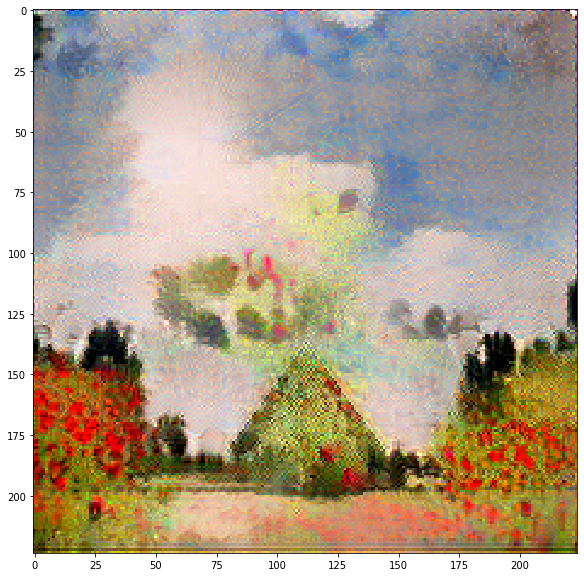

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(generated_img)

In [15]:
Image.fromarray(generated_img).save("generated_image.jpg")

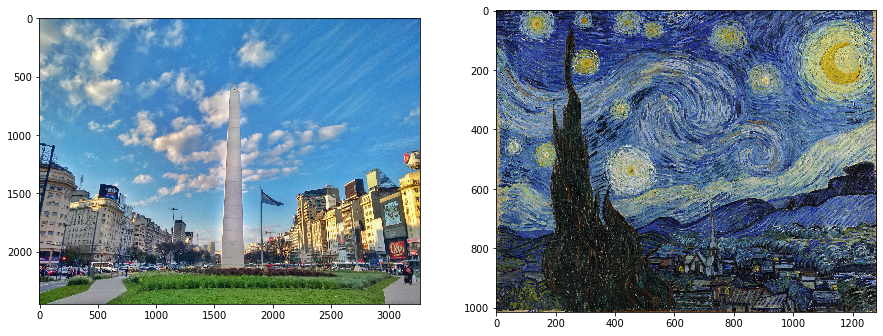

In [16]:
content_img_ = np.array(plt.imread('content_image_.jpeg'))
style_img_ = np.array(plt.imread('style_image_.jpeg'))

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(content_img_)
ax2.imshow(style_img_)

In [17]:
content_image_ = np.array(Image.fromarray(content_img_).resize((224,224)), dtype='float32')
style_image_ = np.array(Image.fromarray(style_img_).resize((224,224)), dtype='float32')

In [18]:
neural_transfer = NeuralTransfer(model=vgg19,
                                 content=content,
                                 style=style)

neural_transfer.fit(content_image=content_image_, style_image=style_image_)

Epochs 1/1000 - Loss: 1.341905211345265e+21
--- 1.794s ---
Epochs 2/1000 - Loss: 1.0450246165780255e+21
--- 1.632s ---
Epochs 3/1000 - Loss: 8.620645447099597e+20
--- 1.649s ---
Epochs 4/1000 - Loss: 7.364609806899452e+20
--- 1.912s ---
Epochs 5/1000 - Loss: 6.491896641608063e+20
--- 1.961s ---
Epochs 6/1000 - Loss: 5.907595403828365e+20
--- 1.971s ---
Epochs 7/1000 - Loss: 5.524110377120558e+20
--- 1.761s ---
Epochs 8/1000 - Loss: 5.243579748956766e+20
--- 1.75s ---
Epochs 9/1000 - Loss: 4.9971941465303024e+20
--- 1.73s ---
Epochs 10/1000 - Loss: 4.749237210046351e+20
--- 1.795s ---
Epochs 11/1000 - Loss: 4.4856344869819384e+20
--- 1.766s ---
Epochs 12/1000 - Loss: 4.2061403904198836e+20
--- 1.767s ---
Epochs 13/1000 - Loss: 3.9255386898244724e+20
--- 1.779s ---
Epochs 14/1000 - Loss: 3.6670056829343393e+20
--- 1.798s ---
Epochs 15/1000 - Loss: 3.4457737399579024e+20
--- 1.822s ---
Epochs 16/1000 - Loss: 3.263463101229852e+20
--- 1.827s ---
Epochs 17/1000 - Loss: 3.111932103048833e+20

Epochs 137/1000 - Loss: 3.025155390830333e+19
--- 1.78s ---
Epochs 138/1000 - Loss: 2.9839329406864065e+19
--- 1.853s ---
Epochs 139/1000 - Loss: 2.9433655795703087e+19
--- 1.87s ---
Epochs 140/1000 - Loss: 2.903442972072739e+19
--- 1.901s ---
Epochs 141/1000 - Loss: 2.8641563221006746e+19
--- 1.894s ---
Epochs 142/1000 - Loss: 2.8254950743424893e+19
--- 1.905s ---
Epochs 143/1000 - Loss: 2.7874506526074864e+19
--- 1.852s ---
Epochs 144/1000 - Loss: 2.7500147006072947e+19
--- 1.817s ---
Epochs 145/1000 - Loss: 2.7131775426395898e+19
--- 1.829s ---
Epochs 146/1000 - Loss: 2.676925104955536e+19
--- 1.832s ---
Epochs 147/1000 - Loss: 2.6412490312667628e+19
--- 1.779s ---
Epochs 148/1000 - Loss: 2.6061350279221084e+19
--- 1.785s ---
Epochs 149/1000 - Loss: 2.5715738590239e+19
--- 1.872s ---
Epochs 150/1000 - Loss: 2.5375637653535326e+19
--- 1.883s ---
Epochs 151/1000 - Loss: 2.5040928721854267e+19
--- 1.89s ---
Epochs 152/1000 - Loss: 2.4711515038172578e+19
--- 1.909s ---
Epochs 153/1000 -

--- 1.837s ---
Epochs 271/1000 - Loss: 6.94053850747555e+18
--- 1.897s ---
Epochs 272/1000 - Loss: 6.885955451737866e+18
--- 1.882s ---
Epochs 273/1000 - Loss: 6.83210027269777e+18
--- 1.906s ---
Epochs 274/1000 - Loss: 6.778966373285495e+18
--- 1.828s ---
Epochs 275/1000 - Loss: 6.726565848128946e+18
--- 1.844s ---
Epochs 276/1000 - Loss: 6.674877806507196e+18
--- 1.875s ---
Epochs 277/1000 - Loss: 6.623884656234201e+18
--- 1.777s ---
Epochs 278/1000 - Loss: 6.573569904635544e+18
--- 1.815s ---
Epochs 279/1000 - Loss: 6.523930802932154e+18
--- 1.862s ---
Epochs 280/1000 - Loss: 6.474966251612406e+18
--- 1.847s ---
Epochs 281/1000 - Loss: 6.426648762885603e+18
--- 1.882s ---
Epochs 282/1000 - Loss: 6.378970640170353e+18
--- 1.943s ---
Epochs 283/1000 - Loss: 6.331920338594562e+18
--- 1.933s ---
Epochs 284/1000 - Loss: 6.285494009867534e+18
--- 1.871s ---
Epochs 285/1000 - Loss: 6.239673512047411e+18
--- 1.834s ---
Epochs 286/1000 - Loss: 6.194462143669076e+18
--- 1.831s ---
Epochs 287/

--- 1.738s ---
Epochs 406/1000 - Loss: 3.36411250558763e+18
--- 1.763s ---
Epochs 407/1000 - Loss: 3.352696551234339e+18
--- 1.815s ---
Epochs 408/1000 - Loss: 3.3413877992647557e+18
--- 1.811s ---
Epochs 409/1000 - Loss: 3.330184325533532e+18
--- 1.8s ---
Epochs 410/1000 - Loss: 3.3190839310174126e+18
--- 1.801s ---
Epochs 411/1000 - Loss: 3.308076994989654e+18
--- 1.804s ---
Epochs 412/1000 - Loss: 3.2971679154967675e+18
--- 1.812s ---
Epochs 413/1000 - Loss: 3.286365763509682e+18
--- 1.805s ---
Epochs 414/1000 - Loss: 3.275660368545841e+18
--- 1.754s ---
Epochs 415/1000 - Loss: 3.265052555238965e+18
--- 1.757s ---
Epochs 416/1000 - Loss: 3.254533802373939e+18
--- 1.71s ---
Epochs 417/1000 - Loss: 3.2441118065321574e+18
--- 1.715s ---
Epochs 418/1000 - Loss: 3.2337843686903644e+18
--- 1.75s ---
Epochs 419/1000 - Loss: 3.2235457164125143e+18
--- 1.803s ---
Epochs 420/1000 - Loss: 3.213392551163724e+18
--- 1.833s ---
Epochs 421/1000 - Loss: 3.2033276217230623e+18
--- 1.817s ---
Epochs 

--- 1.771s ---
Epochs 540/1000 - Loss: 2.4190899580955525e+18
--- 1.767s ---
Epochs 541/1000 - Loss: 2.414763104962347e+18
--- 1.758s ---
Epochs 542/1000 - Loss: 2.410458791817511e+18
--- 1.755s ---
Epochs 543/1000 - Loss: 2.4061712462249984e+18
--- 1.82s ---
Epochs 544/1000 - Loss: 2.401903766719693e+18
--- 1.853s ---
Epochs 545/1000 - Loss: 2.397656903057408e+18
--- 1.815s ---
Epochs 546/1000 - Loss: 2.3934325793834926e+18
--- 1.824s ---
Epochs 547/1000 - Loss: 2.389228321796784e+18
--- 1.804s ---
Epochs 548/1000 - Loss: 2.385047153954259e+18
--- 1.754s ---
Epochs 549/1000 - Loss: 2.380889900489638e+18
--- 1.769s ---
Epochs 550/1000 - Loss: 2.3767546372575724e+18
--- 1.704s ---
Epochs 551/1000 - Loss: 2.372638615478993e+18
--- 1.721s ---
Epochs 552/1000 - Loss: 2.3685423849097134e+18
--- 1.759s ---
Epochs 553/1000 - Loss: 2.3644673199392686e+18
--- 1.847s ---
Epochs 554/1000 - Loss: 2.3604125959339377e+18
--- 1.793s ---
Epochs 555/1000 - Loss: 2.356376838504186e+18
--- 1.801s ---
Epo

Epochs 673/1000 - Loss: 1.986206870120956e+18
--- 1.873s ---
Epochs 674/1000 - Loss: 1.983781622347989e+18
--- 1.851s ---
Epochs 675/1000 - Loss: 1.9813661327407186e+18
--- 1.832s ---
Epochs 676/1000 - Loss: 1.978959576665424e+18
--- 1.833s ---
Epochs 677/1000 - Loss: 1.9765604422936166e+18
--- 1.786s ---
Epochs 678/1000 - Loss: 1.9741680424305295e+18
--- 1.783s ---
Epochs 679/1000 - Loss: 1.9717833391488369e+18
--- 1.826s ---
Epochs 680/1000 - Loss: 1.9694066073264456e+18
--- 1.851s ---
Epochs 681/1000 - Loss: 1.9670371597685883e+18
--- 1.86s ---
Epochs 682/1000 - Loss: 1.964675271353172e+18
--- 1.905s ---
Epochs 683/1000 - Loss: 1.962323965737173e+18
--- 1.893s ---
Epochs 684/1000 - Loss: 1.9599800818246615e+18
--- 1.899s ---
Epochs 685/1000 - Loss: 1.9576451314441257e+18
--- 1.89s ---
Epochs 686/1000 - Loss: 1.9553176027670774e+18
--- 1.84s ---
Epochs 687/1000 - Loss: 1.9529995573778186e+18
--- 2.238s ---
Epochs 688/1000 - Loss: 1.9506875593025126e+18
--- 1.843s ---
Epochs 689/1000 

--- 1.8s ---
Epochs 807/1000 - Loss: 1.722908195006972e+18
--- 1.853s ---
Epochs 808/1000 - Loss: 1.7213085430275113e+18
--- 1.877s ---
Epochs 809/1000 - Loss: 1.7197139762893292e+18
--- 1.915s ---
Epochs 810/1000 - Loss: 1.7181244947924255e+18
--- 1.895s ---
Epochs 811/1000 - Loss: 1.7165396862199398e+18
--- 1.911s ---
Epochs 812/1000 - Loss: 1.7149607875224535e+18
--- 1.933s ---
Epochs 813/1000 - Loss: 1.7133858745546179e+18
--- 1.891s ---
Epochs 814/1000 - Loss: 1.7118142601216655e+18
--- 1.844s ---
Epochs 815/1000 - Loss: 1.7102471811741778e+18
--- 1.854s ---
Epochs 816/1000 - Loss: 1.708684775151108e+18
--- 1.839s ---
Epochs 817/1000 - Loss: 1.7071273169303634e+18
--- 1.792s ---
Epochs 818/1000 - Loss: 1.7055741193171763e+18
--- 1.809s ---
Epochs 819/1000 - Loss: 1.7040265567010816e+18
--- 1.87s ---
Epochs 820/1000 - Loss: 1.7024844916431258e+18
--- 1.913s ---
Epochs 821/1000 - Loss: 1.7009475118264484e+18
--- 1.917s ---
Epochs 822/1000 - Loss: 1.6994165793237238e+18
--- 1.902s --

--- 1.923s ---
Epochs 940/1000 - Loss: 1.5433351313248748e+18
--- 1.84s ---
Epochs 941/1000 - Loss: 1.5421816061883843e+18
--- 1.8s ---
Epochs 942/1000 - Loss: 1.541031654464684e+18
--- 1.789s ---
Epochs 943/1000 - Loss: 1.5398848638369137e+18
--- 1.831s ---
Epochs 944/1000 - Loss: 1.5387393101597245e+18
--- 1.858s ---
Epochs 945/1000 - Loss: 1.5375963678226514e+18
--- 1.906s ---
Epochs 946/1000 - Loss: 1.5364567240204616e+18
--- 1.918s ---
Epochs 947/1000 - Loss: 1.535318866924667e+18
--- 1.894s ---
Epochs 948/1000 - Loss: 1.5341821093405e+18
--- 1.901s ---
Epochs 949/1000 - Loss: 1.5330471384627282e+18
--- 1.91s ---
Epochs 950/1000 - Loss: 1.531914366608212e+18
--- 1.885s ---
Epochs 951/1000 - Loss: 1.530783381460091e+18
--- 1.856s ---
Epochs 952/1000 - Loss: 1.529654183018365e+18
--- 1.807s ---
Epochs 953/1000 - Loss: 1.5285259466493133e+18
--- 1.815s ---
Epochs 954/1000 - Loss: 1.527398672352936e+18
--- 1.811s ---
Epochs 955/1000 - Loss: 1.5262735970798141e+18
--- 1.842s ---
Epochs

In [19]:
generated_img_ = neural_transfer.generated_image

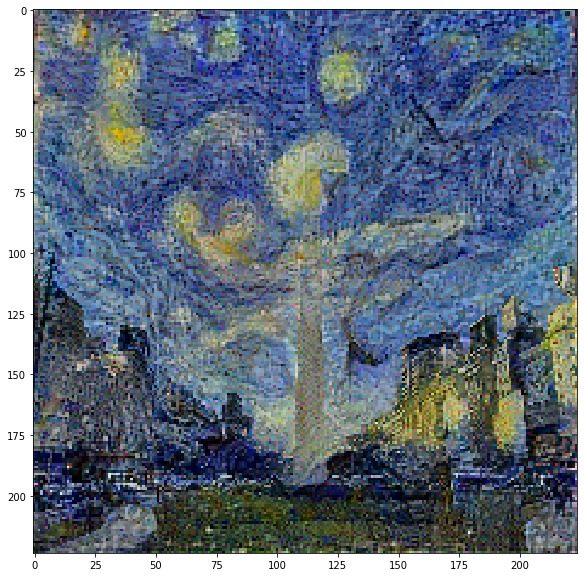

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(generated_img_)

In [21]:
Image.fromarray(generated_img_).save("generated_image_.jpg")